# Video games store historical data analysis

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

## Step 1. Open the data file and study the general information

In [1]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from functools import reduce
from math import factorial
from scipy import stats as st
from statistics import mean 
from IPython.display import display


pd.set_option('display.max_columns', 500)

In [2]:
#load all data tables
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [4]:
data.describe(include='object')

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


In [5]:
data.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1487,Petz Wild Animals: Dolphinz,DS,2007.0,Simulation,0.71,0.48,0.0,0.13,NaN,tbd,E
10425,Kamen Rider: Battride War II,PS3,2014.0,Action,0.00,0.00,0.1,0.00,NaN,NaN,NaN
16071,4 Play Collection - Dark Mysteries,PC,2014.0,Misc,0.00,0.01,0.0,0.00,NaN,NaN,NaN
10893,Adventure Time: Finn & Jake Investigations,PS4,2015.0,Action,0.03,0.05,0.0,0.02,NaN,NaN,NaN
2497,Sid Meier's Civilization Revolution,X360,2008.0,Strategy,0.58,0.17,0.0,0.07,84.0,7.8,E10+
12295,Moshi Monsters: Katsuma Unleashed,3DS,2013.0,Action,0.03,0.03,0.0,0.01,NaN,tbd,E
3680,Iron Man,PS2,2008.0,Action,0.36,0.00,0.0,0.19,47.0,5.6,T
5998,FlatOut: Head On,PSP,2008.0,Racing,0.13,0.10,0.0,0.06,74.0,8.2,T
9033,Second Sight,PS2,2004.0,Adventure,0.07,0.05,0.0,0.02,76.0,8,T
803,Sim Theme Park,PC,1998.0,Strategy,2.04,0.04,0.0,0.00,NaN,8.3,E


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


I see several flaws in this data:
* lot's of zeros for region sales. Need to check if when only one row has had value, others were filled with zeroes;
* User score is not a float and most popular value there is 'to be determined';
* some missing values in Name, Genre, Critic_Score, User_score and Rating
* column names that are not easy to work with.

## Step 2. Prepare the data


In [7]:
#rename columns
data.columns = ['name', 'platform', 'release_date', 'genre', 'na_sales', 'eu_sales',
                        'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

In [8]:
#Now let's see what's going on with missing values
data[data.name.isnull()]

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Looks like these rows come through some old games that aren't in the database. I'll keep them for now, maybe they will have some effect on further anaysis of sales for this platform.

In [9]:
#Now let's check values for release date
data[data.release_date.isnull()]

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Lot's of rows that don't have release date value, we can't drop them and can't fill them with median. But we all gaming platform usually have limited amount of time that games are released, maybe we can fill missing values with median for each platform. Let's firstly analyse year of release for each platform.

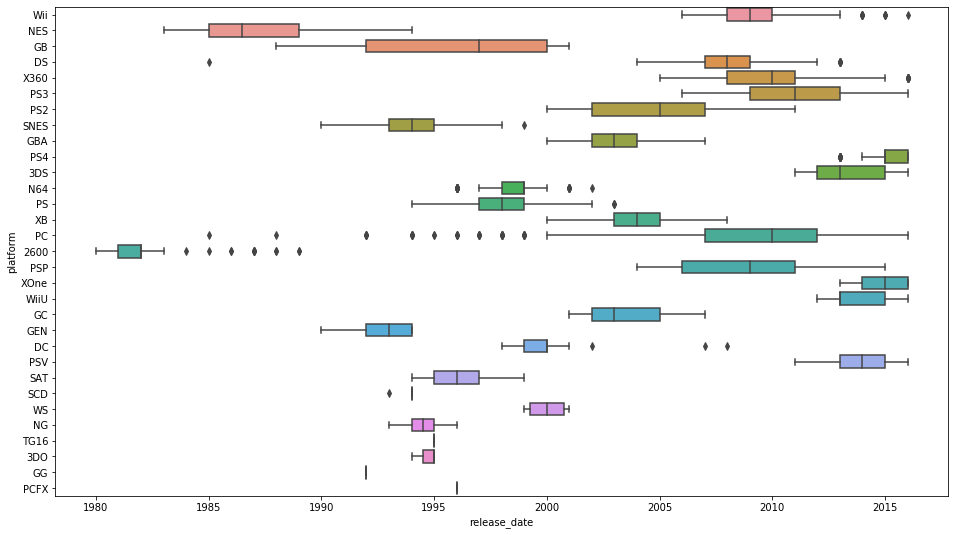

In [10]:
ax = plt.subplots(figsize=(16,9))
fig = sns.boxplot(x=data['release_date'], y=data['platform'], data=data)


My theory confirmed. Games' year of release is pretty much concentrated within form 5 to 10 years for most of big platforms and is even more narrow for smaller ones. Therefore we can freely change release date for missng columns with mean for that platform.

In [11]:
#I'll fill with median using transform method
data['release_date'] = (
    data['release_date']
    .fillna(data.groupby('platform')['release_date'].transform('median'))
    .round(0)
    .astype(int) #change end value to integer
)

In [78]:
data[data.release_date.isnull()]

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


No empty release date left!

In [12]:
#check empty values for critic score
data[data.critic_score.isnull()].sample(10)

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3638,Ratchet & Clank: Quest for Booty,PS3,2008,Platform,0.00,0.52,0.00,0.04,NaN,NaN,NaN
12553,Mike Piazza's Strike Zone,N64,1998,Sports,0.05,0.01,0.00,0.00,NaN,NaN,NaN
7747,Shin Megami Tensei IV: Final,3DS,2016,Role-Playing,0.05,0.00,0.14,0.01,NaN,NaN,NaN
3252,Mario's Picross,GB,1995,Puzzle,0.00,0.00,0.62,0.00,NaN,NaN,NaN
8379,NickToons: Racing,PS,2001,Racing,0.09,0.06,0.00,0.01,NaN,NaN,NaN
8455,Chaotic: Shadow Warriors,PS3,2009,Action,0.15,0.00,0.00,0.02,NaN,tbd,E10+
7023,Rock Band Track Pack Volume 2,Wii,2008,Misc,0.20,0.01,0.00,0.02,NaN,NaN,NaN
14680,Nisekoi: Yomeiri!?,PSV,2014,Adventure,0.00,0.00,0.03,0.00,NaN,NaN,NaN
14643,Kung Fu Panda: Showdown of Legendary Legends,3DS,2015,Action,0.00,0.03,0.00,0.00,NaN,tbd,E10+
11947,Crayola: Colorful Journey,Wii,2009,Misc,0.07,0.00,0.00,0.00,NaN,tbd,E


In [13]:
data[data.critic_score.isnull()].describe()

,release_date,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,8578.000000,8578.000000,8578.000000,8578.000000,8578.000000,0.0
mean,2005.790044,0.178381,0.085059,0.099045,0.023539,NaN
std,7.091343,0.716068,0.321036,0.343936,0.088740,NaN
min,1980.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2001.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2008.000000,0.020000,0.000000,0.000000,0.000000,NaN
75%,2011.000000,0.140000,0.050000,0.060000,0.020000,NaN
max,2016.000000,29.080000,10.950000,10.220000,2.740000,NaN


Looks like we have lots of values that are with empty critic score. It may be due to these games didn't get enough critic reviews or maybe they just weren't filled. I don't see a way to fill them, therefore I'll keep these scores as NaN. I will do the same for empty user_score values, because there is nothing I can do about it.

In [14]:
#Now let's check what's happening with tbd in user_score value
data.query('user_score =="tbd"')

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,2003,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


I see that there are lots of rows with this value, but this aren't recent games, so it's highly unlikely that they are going to get user score assigned. Therefore I think it will be better just to change them to NaN, so they won't affect the data, but first I'll check if they are all really old.

In [15]:
data.query('user_score =="tbd"').release_date.value_counts()

2009    422
2008    338
2010    332
2011    217
2007    192
2002    192
2005    125
2006    124
2004    111
2003    102
2001     82
2000     43
2015     38
2016     34
2012     24
2014     21
2013     17
1999      8
1997      1
1998      1
Name: release_date, dtype: int64

In [16]:
#There are some new games, but overall it's spred all over, I think it's better to change these values to Nan
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = data.user_score.astype(float).copy() #change user_score to float
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name            16713 non-null object
platform        16715 non-null object
release_date    16715 non-null int64
genre           16713 non-null object
na_sales        16715 non-null float64
eu_sales        16715 non-null float64
jp_sales        16715 non-null float64
other_sales     16715 non-null float64
critic_score    8137 non-null float64
user_score      7590 non-null float64
rating          9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [17]:
#let's check if all there aren't any rows that have empty values for sales in all regions
data.query('na_sales==0 & eu_sales==0 & jp_sales==0 & other_sales==0')

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16676,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN


This is a little bit strange. I don't quite understand how did games with 0 in all sales get in this dataset, in real life it would have been better to find out how this dataset was formed to see if we have any mistakes in it. But here I'm just going to drop these rows, because they are no good.

In [18]:
data = data.drop([16676, 16709])

In [19]:
#let's check values for rating
data.rating.value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [20]:
data[data.rating.isnull()].describe()

,release_date,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,83.000000,86.000000
mean,2004.845949,0.183687,0.090750,0.124477,0.022336,68.614458,6.965116
std,7.546940,0.796317,0.348051,0.383074,0.092142,12.633513,1.432954
min,1980.000000,0.000000,0.000000,0.000000,0.000000,31.000000,3.100000
25%,1999.000000,0.000000,0.000000,0.000000,0.000000,62.000000,6.100000
50%,2007.000000,0.000000,0.000000,0.020000,0.000000,70.000000,7.350000
75%,2011.000000,0.120000,0.050000,0.100000,0.010000,77.500000,8.100000
max,2016.000000,29.080000,10.950000,10.220000,2.740000,93.000000,9.200000


There are 6714 rows with empty rating, that's a lot. Also many of these games have empty critic score and user score. I'will leave these rows empty for now and will drop if I won't need them later.

Now I need to calculate total sales for each game in all the regions.

In [21]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.sample(10)

,name,platform,release_date,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
9775,Ninja Reflex,Wii,2008,Action,0.11,0.00,0.00,0.01,49.0,6.0,E10+,0.12
7522,Midnight Club 3: DUB Edition Remix,XB,2006,Racing,0.15,0.04,0.00,0.01,87.0,5.3,E10+,0.20
2588,Motocross Mania,PS,2001,Racing,0.44,0.30,0.00,0.05,34.0,5.3,E,0.79
9133,Spyro: A Hero's Tail,XB,2004,Platform,0.11,0.03,0.00,0.01,64.0,9.1,E,0.15
544,Yoshi's Island DS,DS,2006,Platform,1.45,0.07,1.10,0.15,81.0,7.4,E,2.77
4368,Watch Dogs,PC,2014,Action,0.15,0.26,0.00,0.03,77.0,4.7,M,0.44
15651,Miyako,PSP,2010,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
4144,WipEout,PS,1995,Action,0.26,0.18,0.00,0.03,NaN,NaN,NaN,0.47
6346,Rapala Pro Bass Fishing 2010,PS3,2010,Sports,0.18,0.05,0.00,0.03,NaN,8.5,E,0.26
4671,Tom Clancy's Rainbow Six: Lockdown,XB,2005,Shooter,0.26,0.13,0.00,0.02,74.0,6.6,M,0.41


### Conclusion

1. I have replased missing release year with mean release year for each platform;
2. I have changed "to be determined" values of user score column to NaN, because they aren't going to be determined;
3. I have left empty values for critic score and for rating to stay empty;
4. I have droped rows that had no sales at all;
5. I have calculated total sales for each game and put them in new column.

## Step 3. Analyze the data


#### Look at how many games were released in different years. Check if the data for every period issignificant?

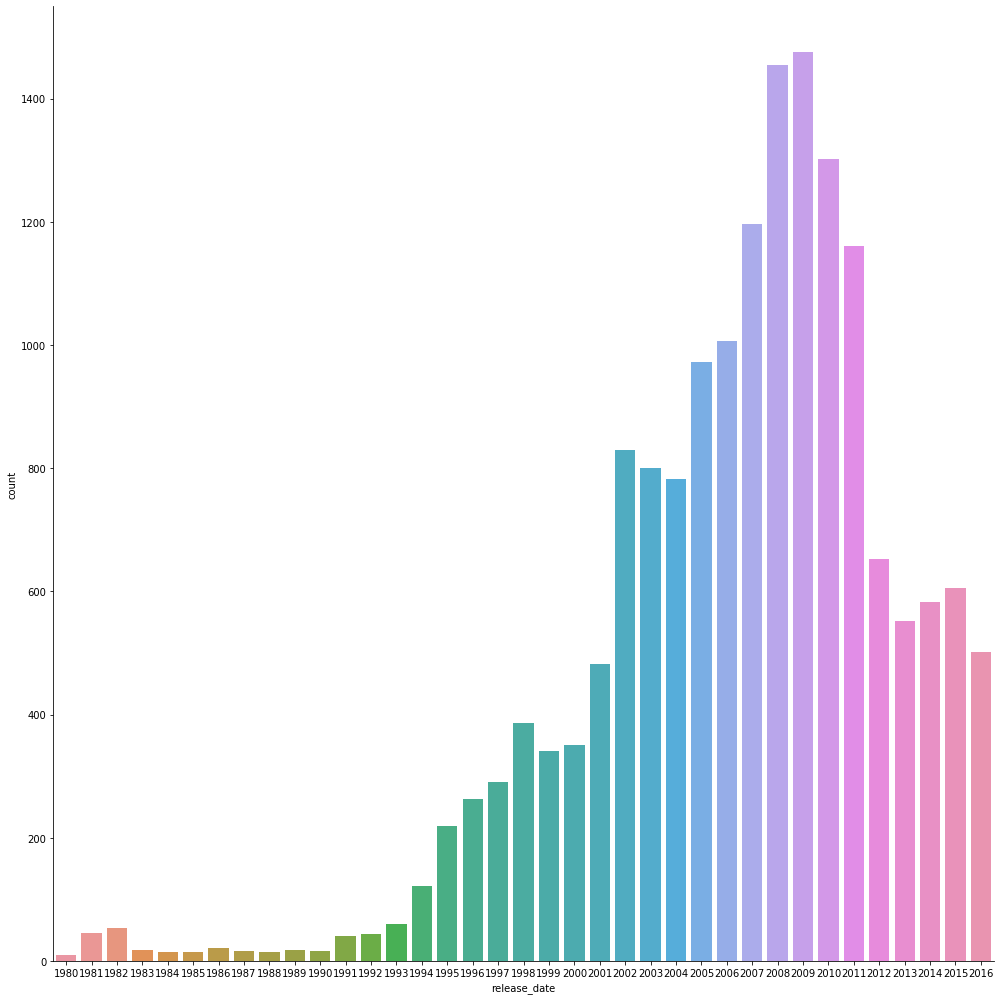

In [22]:
#create dataset with years and amount of games released each year
release_year = (data.groupby('release_date')[['name']].count()
            .reset_index()
            .rename(columns={"name": "count"})
           )
#make a catplot for this dataset.
sns.catplot(x="release_date", y="count", kind="bar", data=release_year, height=14)

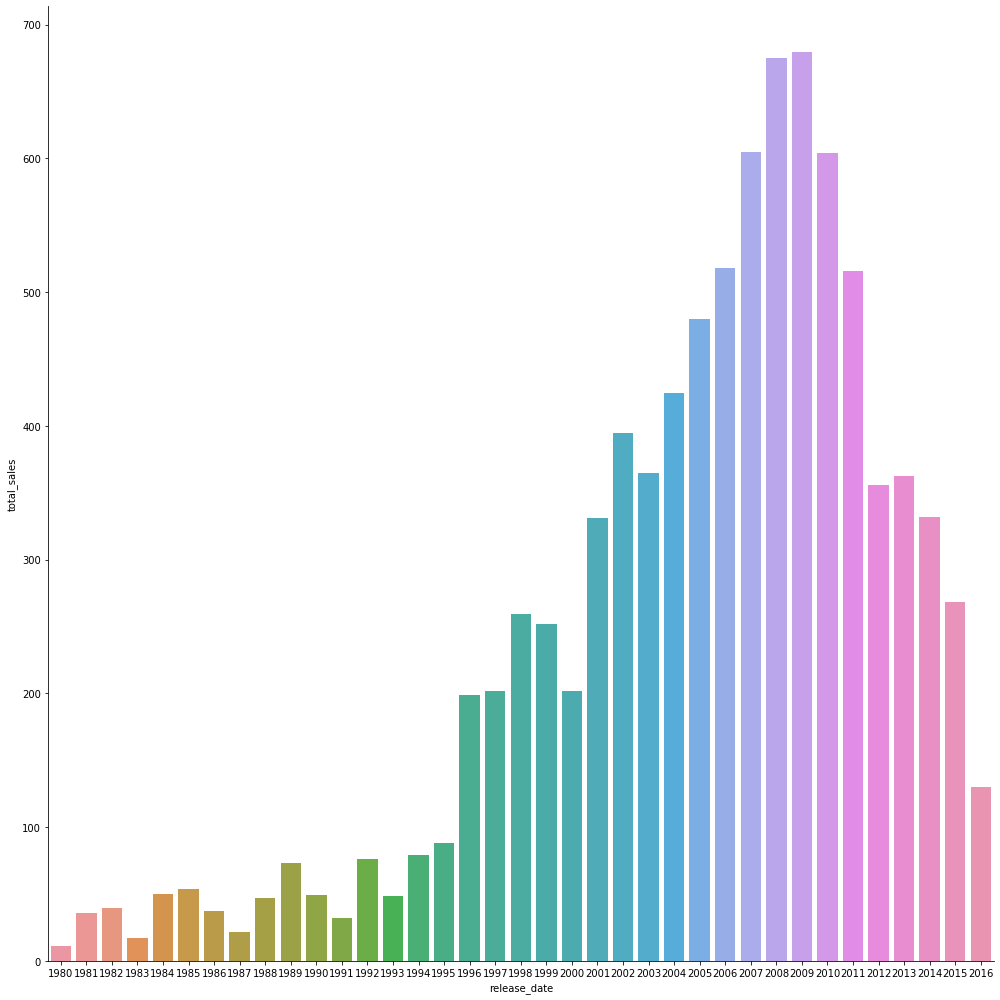

In [23]:
#Now let's do the same but with sales for each year
year_sales = (data.groupby('release_date')[['total_sales']].sum()
            .reset_index()
           )
sns.catplot(x="release_date", y="total_sales", kind="bar", data=year_sales, height=14)

From here I see that before mid 90's game industry had been much smaller than what it became later. So maybe we can ignore data for all data before 1995 as not representive enough. Also It's obvious from this data that industry has picked in 2000's and now is heading towards decline (or maybe stability, we'll see).

#### Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. Find out how long does it generally take for new platforms to appear and old ones to fade.


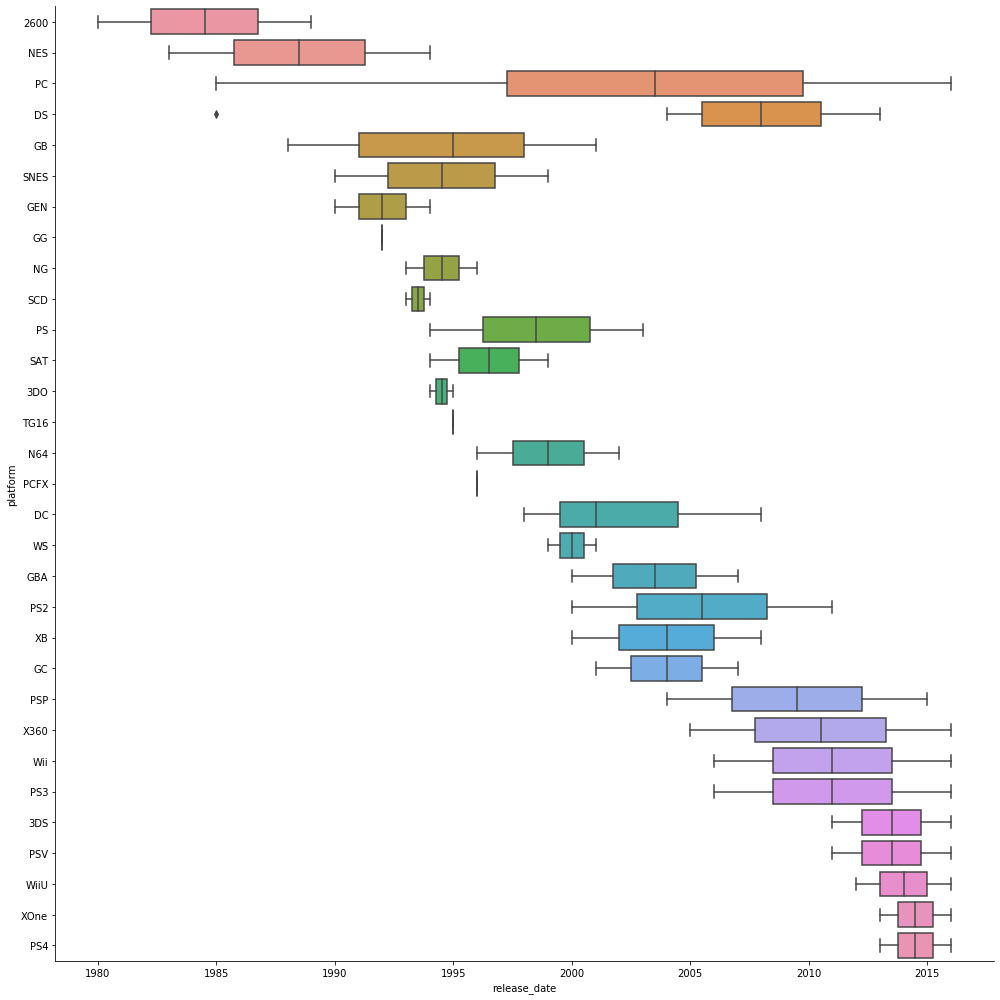

In [24]:
#Let's create table with the data that I'm going to need
df_platform_grouped = (
    data
    .pivot_table(index=['platform', 'release_date'], values='total_sales', aggfunc='sum')
    .reset_index()
    .sort_values('release_date')
)
#look  at lifespan of platforms
sns.catplot(y="platform", x="release_date", kind='box', data=df_platform_grouped, height=14);

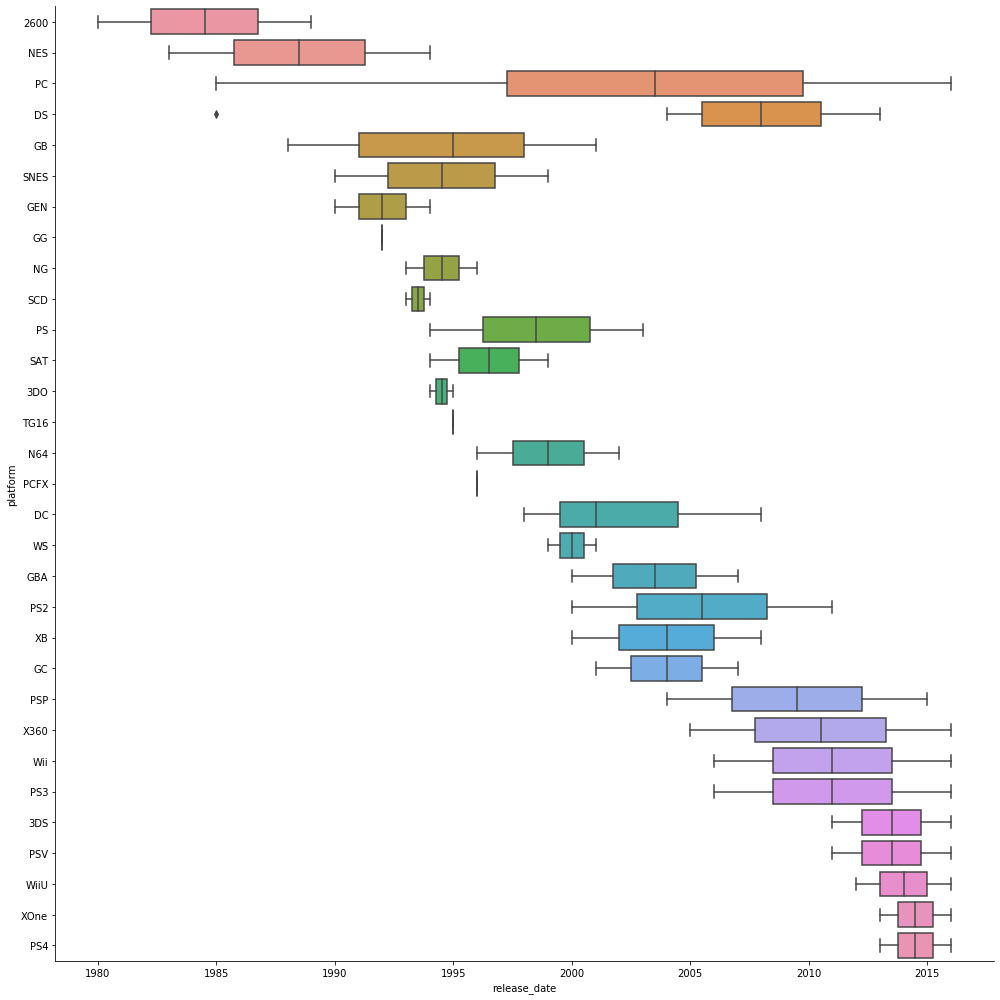

In [25]:
#look at lifespan of platforms
sns.catplot(y="platform", x="release_date", kind='box', data=df_platform_grouped, height=14);

Looks loke lifespan of gaming platfroms is different for different platforms. Some platforms stayed on market for reletively short time, but others stayed on the market for much longer time. Let's select most popular ones based on their  total sales.

In [26]:
#Create list of topselling platfroms
topsellers = (
    data
    .groupby('platform')["total_sales"].sum()
    .sort_values(ascending=False)
    .head(10) #get top 10
    .index.tolist() #turn it to list
)

#dataframe, that contains data only for topsellers
df_topselling = data.query('platform in @topsellers') 
print('Topselling platfrorms:', topsellers)
print ('Games for topselling platforms:', df_topselling.shape[0])
print ('Percentage of games for topselling platforms: {:.2%}'.format(df_topselling.shape[0]/len(data)))

Topselling platfrorms: ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']
Games for topselling platforms: 12817
Percentage of games for topselling platforms: 76.69%


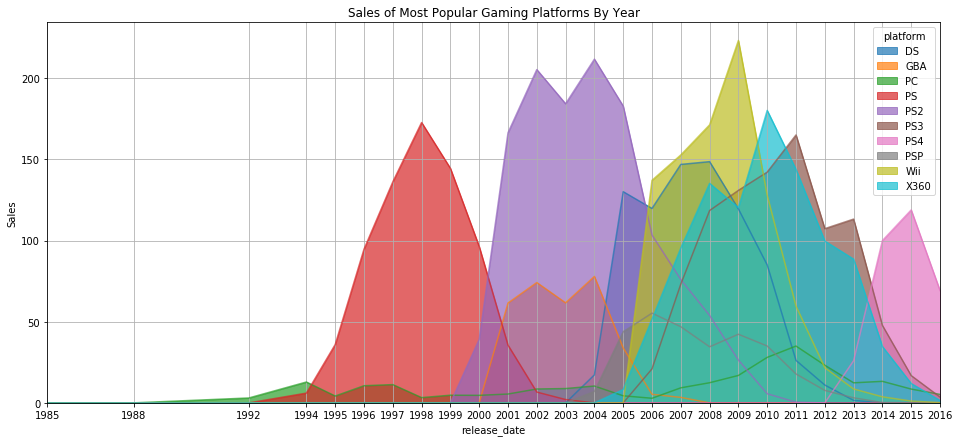

In [27]:
fig, ax = plt.subplots()
ax.set_ylabel('Sales')
ax.set_title('Sales of Most Popular Gaming Platforms By Year')
plt.xticks(df_topselling.release_date.unique()) #set ticks for plot
(df_topselling.pivot_table(index='release_date', columns='platform', values='total_sales',
                         aggfunc='sum')
 .plot(kind='area', stacked=False, alpha=0.7, grid=True, figsize=(16,7), ax=ax)
)

From this plot I see that some of the most popular platforms have no sales nowaday, because they have become outdated. For example PlayStation didn't get much sales since 2005 and PlayStation 2 didn't get much since 2011. We can see from this plot that on average lifespan of a popular platform lasts for around 8-10 years. 

There is one exception here - PC, it's lifespan was much longer, because for a long time PC provided the same possibilities as other platforms, it has even become more popular than all the others in late 2000's. But after that it seems like PCs stopped to satisfy gamers' requirements and it has also gone to decline.

Also I see that we are able to disregard all the games that have been released before 2000 as all other data is too old for us to be useful.

In [28]:
df_modern = data.query('release_date >=2000')

Now I'm going to find out which platform were successful and which weren't. I'll do it by looking at Z score.

In [29]:
df = (df_modern[['platform', 'total_sales']].groupby('platform')
      .sum()
      .sort_values(by='total_sales')
      .reset_index())
df

,platform,total_sales
0,WS,0.96
1,DC,7.41
2,GB,29.00
3,N64,37.30
4,PSV,54.07
5,WiiU,82.19
6,PS,140.70
7,XOne,159.32
8,GC,198.93
9,PC,209.48


In [30]:
df['sales_z']=(df['total_sales'] - df['total_sales'].mean())/df['total_sales'].std()
df.sample(5)

,platform,total_sales,sales_z
10,XB,257.74,-0.271229
0,WS,0.96,-0.938404
9,PC,209.48,-0.396620
7,XOne,159.32,-0.526947
5,WiiU,82.19,-0.727350


In [31]:
df['colors']=['red' if x<0 else 'green' for x in df['sales_z']]
df.sample(5)

,platform,total_sales,sales_z,colors
19,PS2,1255.77,2.321891,green
0,WS,0.96,-0.938404,red
5,WiiU,82.19,-0.727350,red
7,XOne,159.32,-0.526947,red
18,X360,971.42,1.583082,green


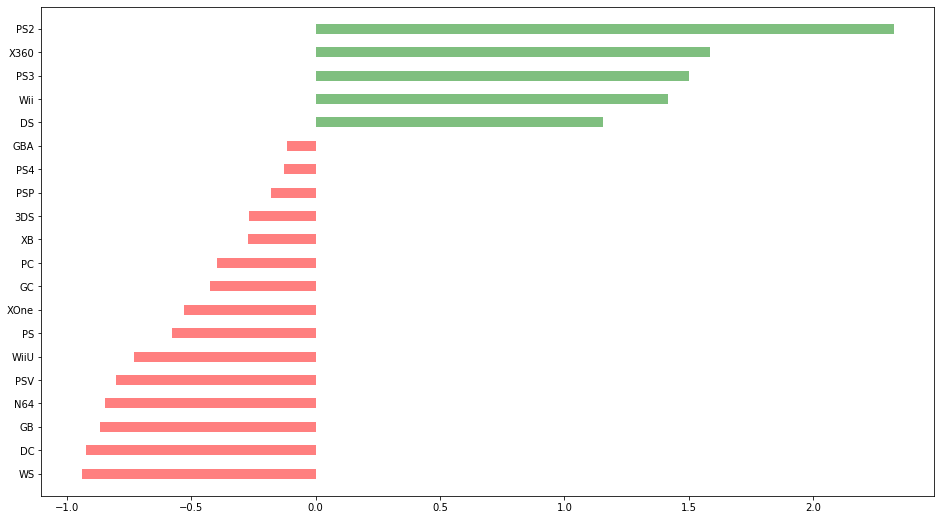

In [32]:
plt.figure(figsize=(16,9))
plt.hlines(y=df.platform, xmin=0, xmax=df.sales_z, color=df.colors, alpha=0.5, linewidth=10)

So we see here that there are some platforms that have been way more successful than others, the alltime leaders are PS2, X360 and PS3. But actually the "losers" aren't so far behind.

#### Find out which platforms are leading in sales, Which ones are growing or shrinking. Select several potentially profitable platforms.

For this step let's compare sales for each platform for each year with value from previous year and find out which platforms have been rising and which have been shifting for each year.

In [33]:
df = df_modern.pivot_table(index='release_date', columns='platform', values='total_sales', aggfunc=sum, fill_value=0)
df.tail()

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
release_date,,,,,,,,,,,,,,,,,,,,
2012,51.36,0.0,11.01,0.0,0.0,0.0,0.0,23.22,0.0,0.0,107.36,0.00,7.69,16.19,0.0,21.71,17.56,99.74,0.0,0.00
2013,57.76,0.0,1.54,0.0,0.0,0.0,0.0,12.38,0.0,0.0,113.25,25.99,3.14,10.59,0.0,8.59,21.65,88.58,0.0,18.96
2014,43.76,0.0,0.00,0.0,0.0,0.0,0.0,13.28,0.0,0.0,47.76,100.00,0.24,12.16,0.0,3.75,22.03,34.74,0.0,54.07
2015,27.78,0.0,0.00,0.0,0.0,0.0,0.0,8.52,0.0,0.0,16.82,118.90,0.12,6.25,0.0,1.14,16.35,11.96,0.0,60.14
2016,15.14,0.0,0.00,0.0,0.0,0.0,0.0,5.25,0.0,0.0,3.60,69.25,0.00,4.25,0.0,0.18,4.60,1.52,0.0,26.15


In [34]:
#let's find dynamic using shift method
dynamic = (df - df.shift(+1)).transpose()
dynamic.tail()

release_date,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,
Wii,NaN,0.00,0.00,0.00,0.00,0.00,137.15,15.62,18.55,51.98,-95.35,-68.30,-37.94,-13.12,-4.84,-2.61,-0.96
WiiU,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.56,4.09,0.38,-5.68,-11.75
X360,NaN,0.00,0.00,0.00,0.00,8.25,43.37,43.79,39.85,-14.97,59.92,-36.37,-44.10,-11.16,-53.84,-22.78,-10.44
XB,NaN,21.27,25.75,7.03,16.55,-22.51,-39.04,-9.49,-0.37,-0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
XOne,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.96,35.11,6.07,-33.99


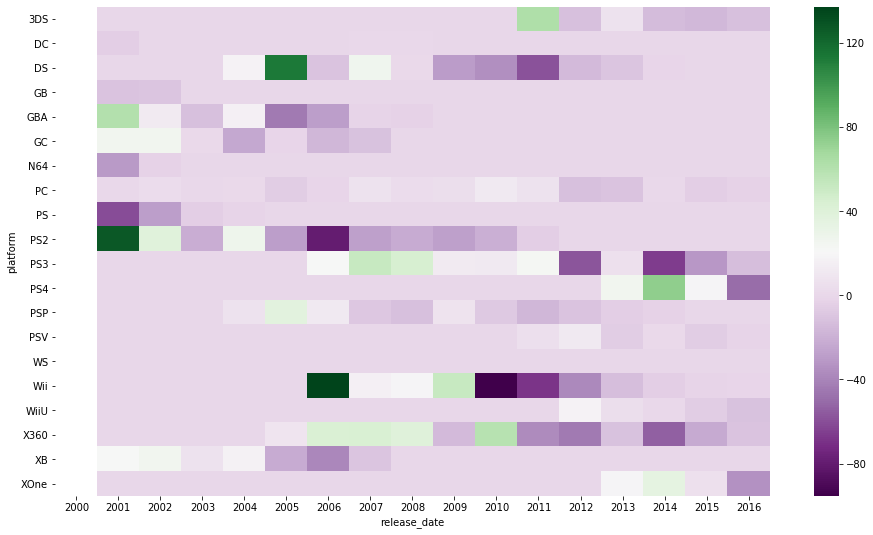

In [35]:
plt.figure(figsize=(16,9))
sns.heatmap(dynamic, cmap='PRGn')

From this heatmap I can see once again see that actually there aren't any rising platforms for 2015-2016 years, but the most popular and worth buying games for are PS4 and XOne, because they are currently beeing used, still have some number of sales (even though they are in decline).

#### Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.


In [36]:
#create a new dataframe for sales for year for every platform
df = df_modern.groupby(['platform', 'release_date'])['total_sales'].sum().reset_index()
#create list of platforms sorted from least profitable to the most profitable
platform_list = data.groupby('platform')['total_sales'].sum().sort_values().reset_index()['platform']
df

,platform,release_date,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,57.76
3,3DS,2014,43.76
4,3DS,2015,27.78
...,...,...,...
145,XB,2008,0.18
146,XOne,2013,18.96
147,XOne,2014,54.07
148,XOne,2015,60.14


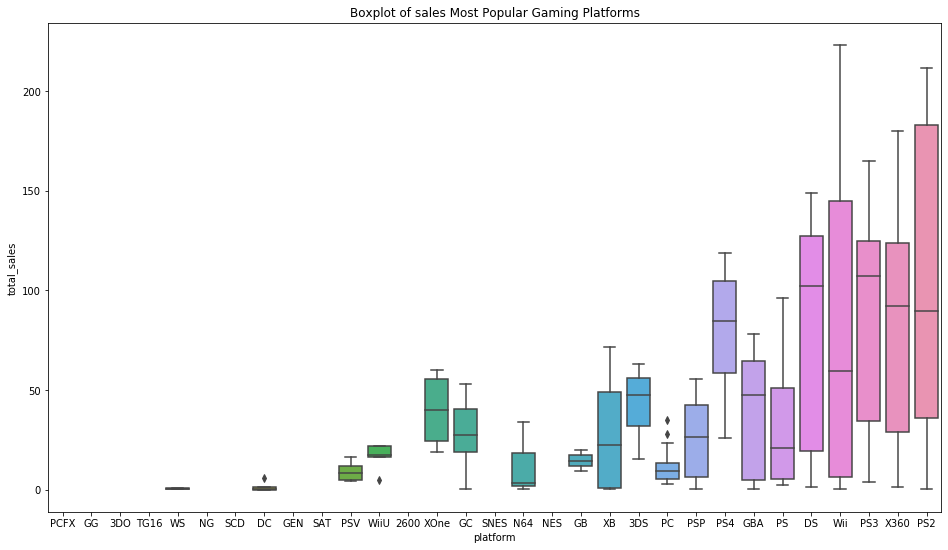

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Boxplot of sales Most Popular Gaming Platforms')
sns.boxplot(y="total_sales", x="platform", data=df, order=platform_list, ax=ax)

From this plot I see that even though in absolute values PS2 has been the most profitable platform over time, its average amount of total sales has been less that for X360 or PS3. I also see here that PS4 and Xone that are popular now had never had as few sales as all other platforms have already experienced, so they are definatly expecting some more sales.

#### Take a look at how user and professional reviews affect sales for one popular platform. Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

For this ananlysis I'm going to check data for popular platform PS3.

In [38]:
df = data.query('platform =="PS3"')[['total_sales', 'critic_score','user_score']]

In [39]:
df.shape

(1330, 3)

In [40]:
#Now let's check what amount of missing values are here
print ('Percentage of NaN in user_score: {:.2%}'.format(len(df[df.user_score.isna()])/len(df.user_score)))
print ('Percentage of NaN in critic_score: {:.2%}'.format(len(df[df.critic_score.isna()])/len(df.critic_score)))

Percentage of NaN in user_score: 34.06%
Percentage of NaN in critic_score: 38.35%


So we really have a lot of missing values here, and there is no way for me to fill this values. Therefore our analysis of this data will not be representive enough, in real life situation I would have to get this data from the client of some other place for my analysis to be more percise. Here I'm going to drop these values for each score.

In [41]:
df.describe()

,total_sales,critic_score,user_score
count,1330.000000,820.000000,877.000000
mean,0.706504,70.382927,6.726568
std,1.392138,14.043094,1.461223
min,0.010000,13.000000,0.200000
25%,0.110000,61.000000,6.000000
50%,0.270000,73.000000,7.100000
75%,0.750000,81.000000,7.800000
max,21.050000,98.000000,9.100000


Looks like we have some definite outliers with very high amount of sales for game, they will affect our analysis. Let's look at them.

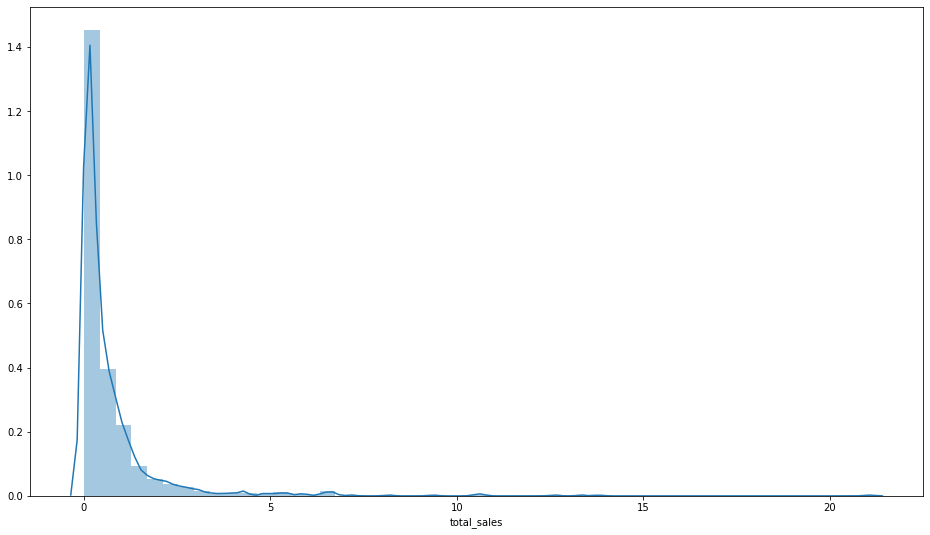

In [42]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(df['total_sales'], ax=ax);

Most of the games didn't even have 0.5 million dollars in sales, but some have gone way to far from there.

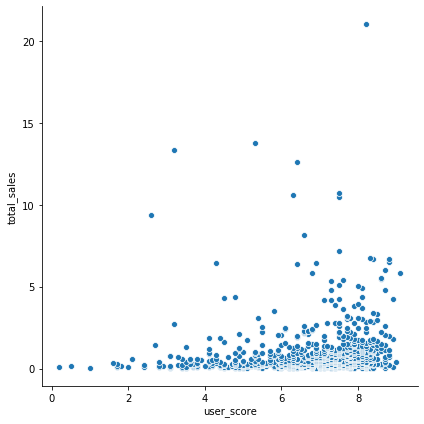

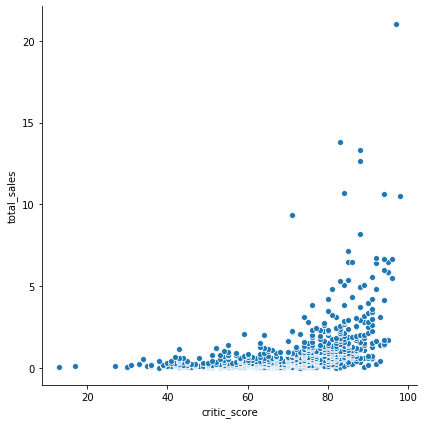

In [43]:
for col in ['user_score', 'critic_score']:
    df_notna = df[df[col].notnull()]
    sns.relplot(y="total_sales", x=col, data=df_notna.sort_values('total_sales'), height=6);


I can see that critics' rating is showing much more correlation to amount of total sales of the most profitable games than users' rating. 

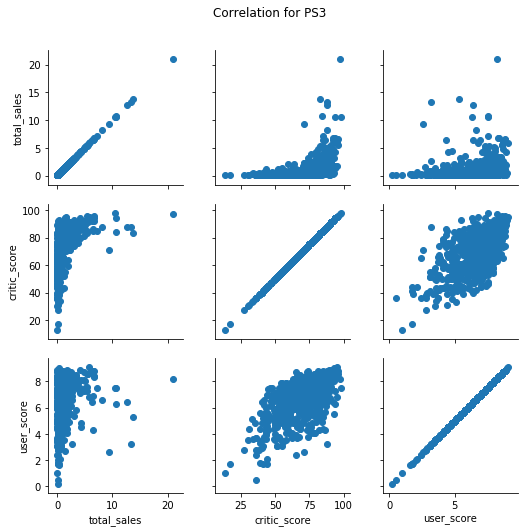

In [44]:
g = sns.PairGrid(df)
g.fig.suptitle('Correlation for PS3')
plt.subplots_adjust(top=0.9)
g.map(plt.scatter);

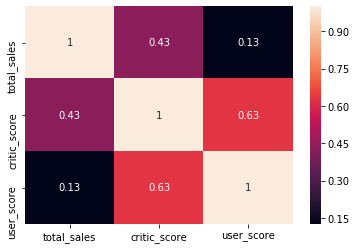

In [45]:
fig, ax = plt.subplots(figsize=(6,4))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, ax=ax)

From this analysis I can make a conclusion that critics' score has some correlation to total sales of each game, but user_score doesn't show anything valuable. So I would suppose for the gamestore to take in slight consideration critic score for the games he'll be purchasing, but to completelly ignore user score (haters gonna hate).

#### Keeping your conclusions in mind, compare the sales of the same games on other platforms.


Okay so to check my conclusions I will take other gaming platforms that were popular at the same era as PS3 and calculate this correlations for them. I'll take X360, PC, Wii and PS2.

In [46]:
def platform_sales_score(data, platform):
    #platform for getting paired grid and correlation matrix for each platform 
    
    df = data.query('platform ==@platform')[['total_sales', 'critic_score','user_score']] #create slice of df
#     print ('Platform: ', platform) 
    #create pairgrid
    g = sns.PairGrid(df)
    g.fig.suptitle('Correlation for {}'.format(platform))
    plt.subplots_adjust(top=0.9)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter);    
    
    #create corrmatrix
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('Correlation matrix for {}'.format(platform))

    corrMatrix = df.corr()
    sns.heatmap(corrMatrix, annot=True)

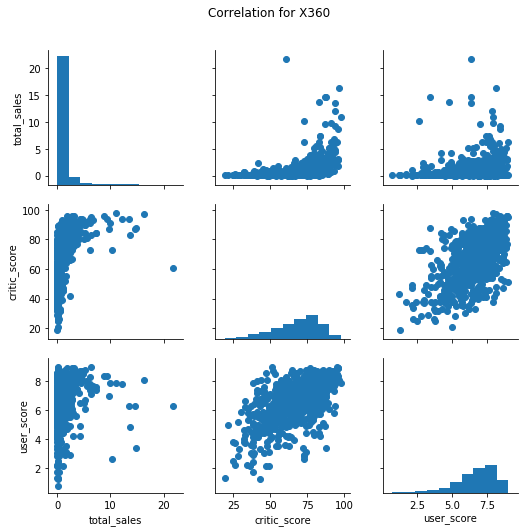

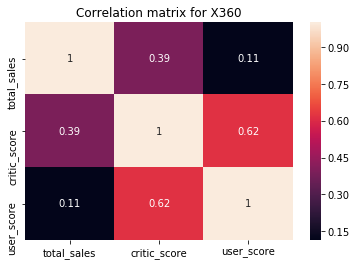

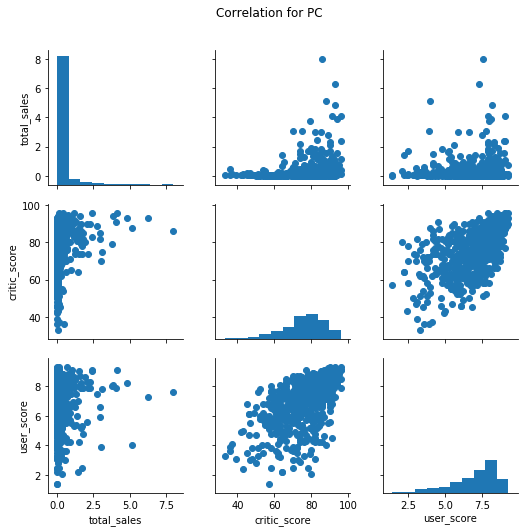

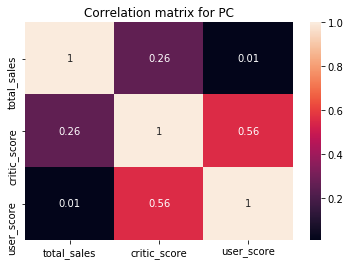

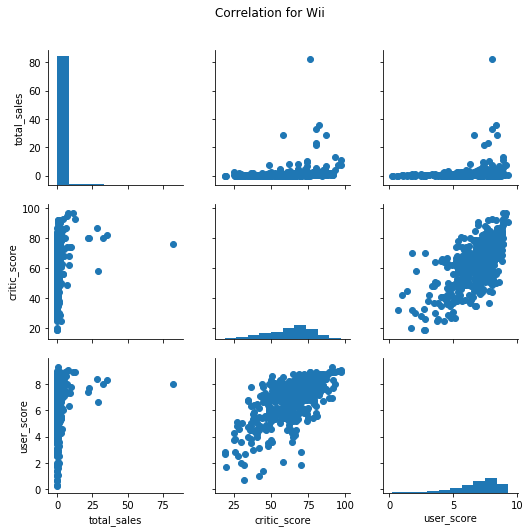

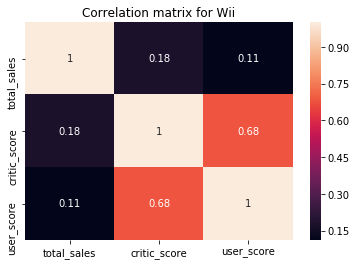

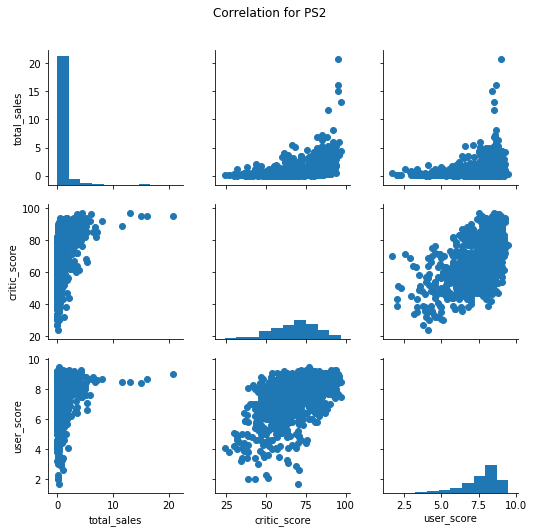

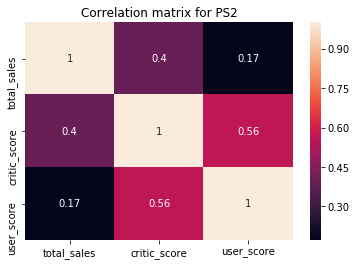

In [47]:
for platform in ['X360', 'PC', 'Wii', 'PS2']:
    platform_sales_score(data, platform)

From here I see that this correlation has been simillar for all the popular platforms in 2000s. All this platforms have around 0.5 correlation between critic score and total sales, and almost no correlation between user score and total sales. So my recomendation stays the same: ignore user score and pay some attention to critic score, games with higher critic score are more likely to have higher sales.

#### Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales


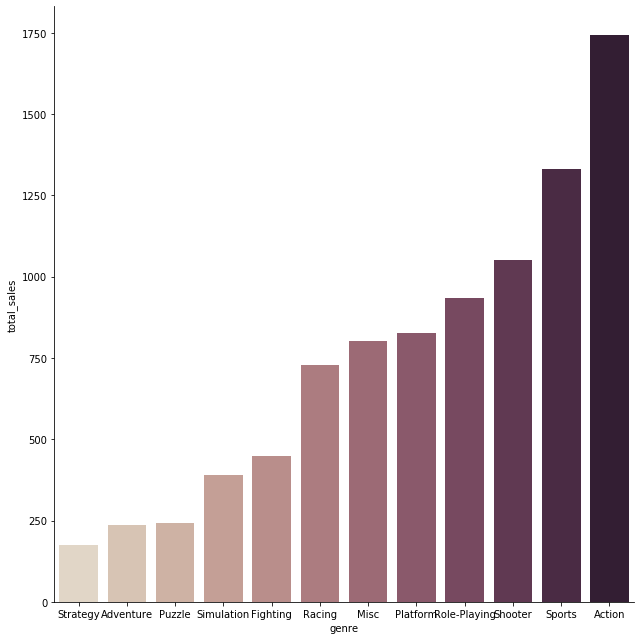

In [48]:
df = data.groupby('genre')[['total_sales']].sum().sort_values(by='total_sales').reset_index()

sns.catplot(x="genre", y='total_sales', kind="bar", palette="ch:.25", data=df, height=9)

So I see that the most overall popular genre is action. Sport is also pretty close. Let's look at how it changed throughout the years. I'll have the data normalized, because amount of sales has changed drasticly over the years.

In [49]:
genre_year_df = (data.pivot_table(index='genre', 
                                 values='total_sales', columns='release_date', 
                                      aggfunc='sum')
                      .fillna(0) #fill empty values
                      .apply(lambda x:100 * x / float(x.sum())).round(2) 
                      #get % of total for each year instead of abcolute value
)
genre_year_df

release_date,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,2.99,41.45,23.97,17.02,3.67,6.52,37.06,5.12,3.69,6.33,12.94,20.97,5.04,3.94,1.96,4.06,10.34,13.65,15.69,11.07,16.85,17.91,21.94,19.22,18.35,17.86,12.76,17.34,20.19,21.70,19.71,23.34,33.51,33.91,29.30,26.88,23.17
Adventure,0.00,0.00,3.30,2.38,0.00,0.00,0.00,20.18,0.00,0.00,0.00,6.95,16.08,0.15,4.72,0.81,2.10,2.46,3.56,3.02,1.47,2.76,2.81,1.24,2.03,1.76,2.19,3.99,3.67,2.99,2.64,3.03,1.63,1.71,1.68,3.05,2.94
Fighting,6.77,0.00,1.19,0.00,0.00,1.95,0.00,24.98,0.00,0.00,0.00,1.21,20.00,19.03,10.70,16.84,9.06,5.84,12.20,5.68,10.05,5.46,6.31,6.52,4.12,4.80,4.33,2.89,5.19,4.71,2.46,4.34,2.58,1.96,4.78,2.95,3.44
Misc,23.73,0.00,2.21,12.74,2.88,0.00,0.00,0.00,0.00,1.74,0.00,0.25,6.49,0.65,3.61,7.26,5.35,2.81,4.58,8.21,7.71,4.94,3.96,6.60,7.55,13.21,12.94,15.12,12.76,11.71,16.21,10.92,6.24,6.97,7.05,4.32,2.00
Platform,0.00,19.39,12.77,41.25,1.37,80.02,25.32,8.02,58.74,28.13,46.55,23.67,17.61,40.62,36.30,18.94,14.18,11.33,11.49,8.26,7.96,11.87,11.63,11.80,11.11,4.94,9.52,5.80,5.21,5.97,5.14,5.46,5.16,6.77,2.66,2.26,2.49
Puzzle,0.00,6.31,28.09,4.64,6.24,5.95,0.00,0.00,11.82,51.40,12.13,10.05,6.36,6.89,1.93,3.05,1.97,2.90,2.45,0.53,1.90,2.40,1.35,0.92,1.98,4.24,2.07,3.90,2.31,2.92,1.80,0.99,0.48,0.26,0.45,0.26,0.01
Racing,0.00,1.35,5.49,0.00,11.82,0.00,5.29,0.00,4.53,0.00,12.66,3.54,11.88,0.78,2.75,6.91,14.20,15.79,10.86,14.77,9.92,16.84,7.63,14.33,11.28,12.10,6.53,6.41,10.38,4.96,5.87,6.91,3.82,3.44,5.02,3.01,2.15
Role-Playing,0.00,0.00,0.00,0.00,0.00,0.00,6.80,21.43,12.45,3.00,9.16,10.11,9.01,12.15,9.00,16.19,22.09,10.80,10.82,19.63,14.41,6.64,11.43,8.34,12.70,6.32,11.08,7.19,8.78,6.97,11.60,10.25,13.18,12.27,13.83,14.05,13.99
Shooter,62.13,28.08,18.59,2.92,61.77,1.85,10.49,3.18,1.08,1.62,0.00,6.17,0.37,6.70,10.48,4.71,3.46,10.96,3.78,4.86,3.39,7.49,12.27,7.43,11.38,8.71,7.39,11.68,8.77,10.54,13.25,19.08,20.16,17.14,19.65,25.19,29.41


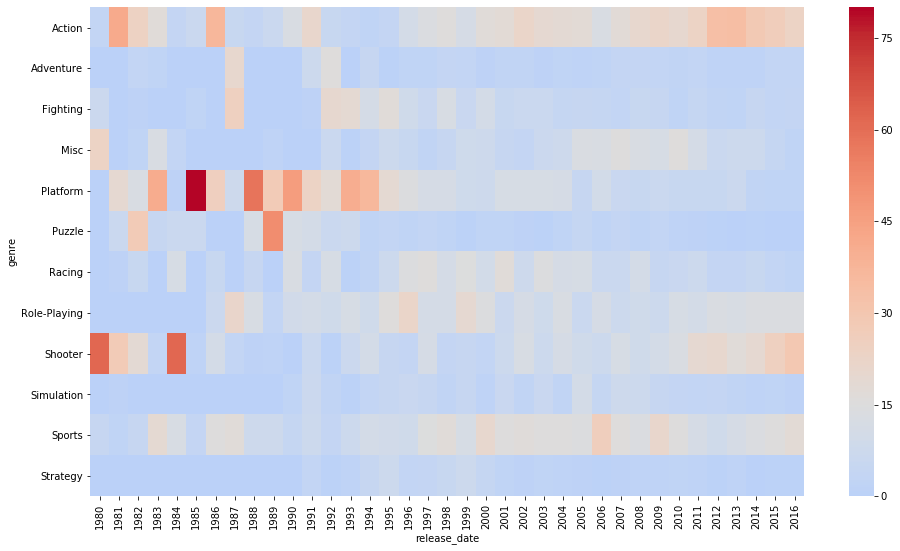

In [50]:
plt.figure(figsize=(16,9))
sns.heatmap(genre_year_df, cmap='coolwarm', center=15)

From this I see that several things:
* There are some genres that used to be popular be very popular before (like platform or puzzle. But have completely lost their popularity over the years;
* Platform games have been ppopular through 80's and 90's but now nobody really plays them;
* Action games have been very popular since the begining of gaming industry;
* Shooter games have been popular in the 80's, then lost their popularity, but now they seem to be getting it back on the market. There are more sales every year (so I recomend to buy more of these in folowing years);
* Sport games maintain their popularity through the years. There always are some people willing to play them;
* Nobody has ever liked strategy games :(

## Step 4. Create a user profile for each region

In [51]:
data
df = data.groupby('rating').sum().sort_values('eu_sales', ascending = False)[['eu_sales']].reset_index().head()
# sns.catplot(y='top_platforms',x=df.rating, height=6, palette='muted', data=df)
df

,rating,eu_sales
0,E,710.25
1,M,483.97
2,T,427.03
3,E10+,188.52
4,AO,0.61


In [52]:
def region_user_profile (data, region_sales):
    
    df = data[['name', 'platform', 'release_date','genre', region_sales, 'rating']]
    #get a Series for most popular platforms
    top_platforms = (data.groupby('platform')
                     .sum().sort_values(region_sales, ascending = False)[region_sales]
                     .head())
    top_genres = data.groupby('genre').sum().sort_values(region_sales, ascending = False)[[region_sales]].head()
    top_ratings = data.groupby('rating').sum().sort_values(region_sales, ascending = False)[[region_sales]].head()
    
    region_sale = pd.DataFrame({'top_platforms': list(top_platforms.index), 'top_genres': list(top_genres.index),
                                'top_ratings': list(top_ratings.index)})
#     sns.catplot(y='top_platforms',)
    return region_sale


In [53]:
for region in ['eu_sales', 'na_sales', 'jp_sales', 'other_sales']:
    print (region)
    region_sales = region_user_profile(data, region)
#     g = sns.catplot(x="class", y="survived", hue="sex", data=titanic,
#                 height=6, kind="bar", palette="muted")
    display(region_sales)

eu_sales


,top_platforms,top_genres,top_ratings
0,PS2,Action,E
1,PS3,Sports,M
2,X360,Shooter,T
3,Wii,Racing,E10+
4,PS,Misc,AO


na_sales


,top_platforms,top_genres,top_ratings
0,X360,Action,E
1,PS2,Sports,T
2,Wii,Shooter,M
3,PS3,Platform,E10+
4,DS,Misc,K-A


jp_sales


,top_platforms,top_genres,top_ratings
0,DS,Role-Playing,E
1,PS,Action,T
2,PS2,Sports,M
3,SNES,Platform,E10+
4,3DS,Misc,K-A


other_sales


,top_platforms,top_genres,top_ratings
0,PS2,Action,E
1,PS3,Sports,M
2,X360,Shooter,T
3,Wii,Racing,E10+
4,DS,Misc,EC


From this I see that in different regions different games were popular and different genres have been popular throughout the time. But most of top platforms are the same, so let's look at the combined data and create charts for it.

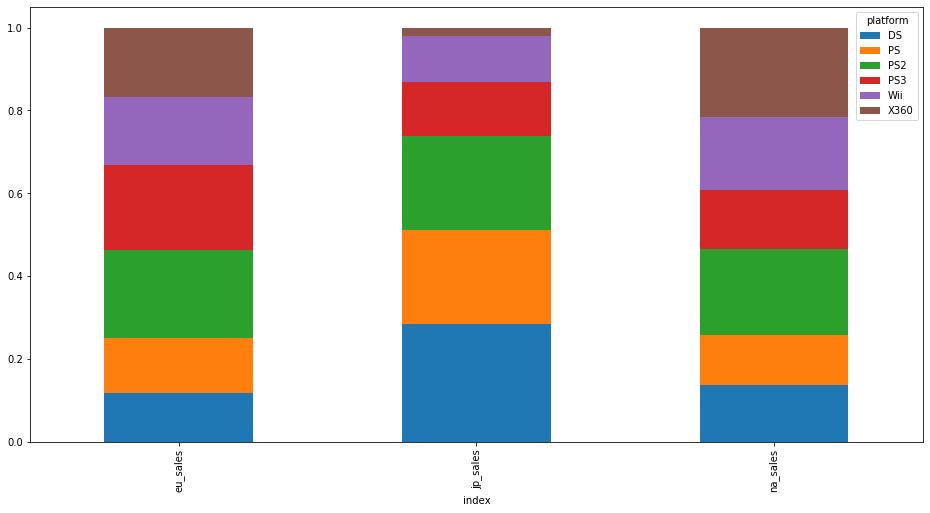

In [54]:
top_platforms = ['X360', 'PS2', 'Wii', 'PS3', 'DS', 'PS', 'PS3']
df = data.query('platform in @top_platforms')
df = df.pivot_table(index=['platform'], values=['eu_sales','jp_sales','na_sales'], aggfunc='sum')
df = df.apply(lambda x: x / float(x.sum())).transpose().reset_index() #change absolute values to percentages

fig, ax = plt.subplots(figsize=(16,8))
df.plot(kind='bar', x='index', stacked=True, ax=ax)


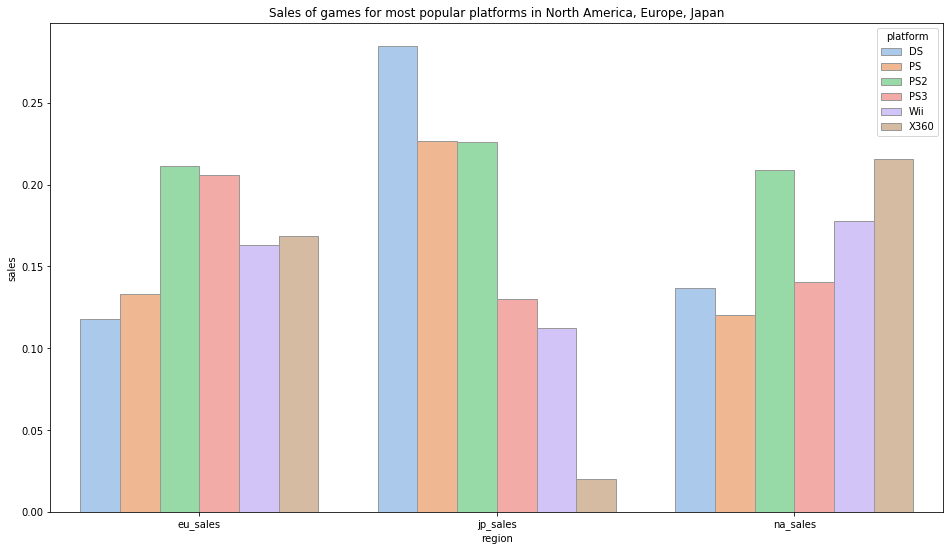

In [55]:
df = data.query('platform in @top_platforms')
df = (df.pivot_table(index=['platform'], values=['eu_sales','jp_sales','na_sales'], aggfunc='sum')
      .apply(lambda x: x / float(x.sum()))
      .reset_index()
      .melt(id_vars='platform')
     )
df.columns = ['platform', 'region', 'sales']
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title('Sales of games for most popular platforms in North America, Europe, Japan')

sns.barplot(x='region', y='sales', hue='platform', data=df, palette="pastel", edgecolor=".6", ax=ax)

# # sns.set()
# # df.set_index('region').T.plot(kind='bar', stacked=True)
# # ig, ax = plt.subplots(figsize=(16,8))
# # df.plot(kind='bar', x='region', y='sales', hue='platform', stacked=True, ax=ax)

# from matplotlib.colors import ListedColormap

# df.set_index('platform')\
#   .reindex(df.set_index('platform').sum().sort_values().index, axis=1)\
#   .T.plot(kind='bar', stacked=True,
#           colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
#           figsize=(12,6))

So here I see that some gaming platforms hthat are popular in one region, aren't popular in others at all. For example very few people have played X360 in Japan, while it has been the biggest platform in North America.

### The top five genres. Explain the difference.


For analysing genre I'll do the same visualisation.

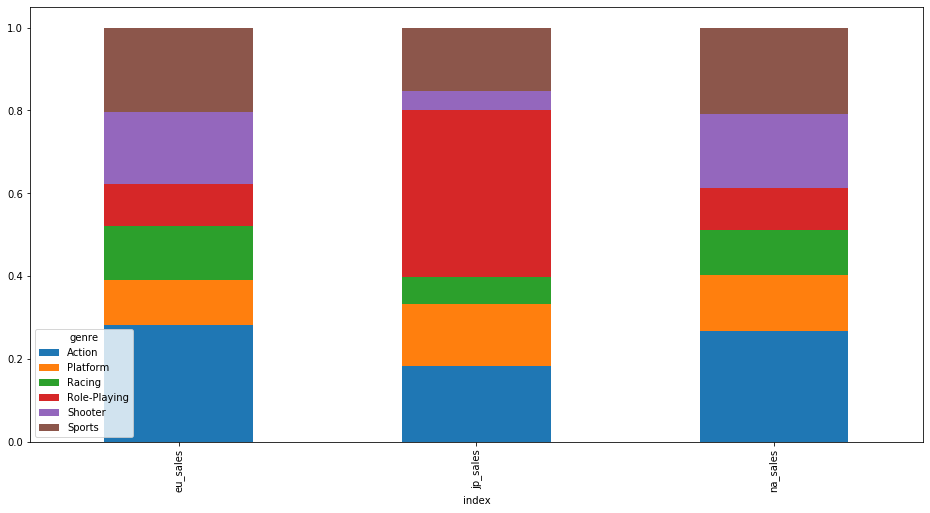

In [56]:
top_genres = ['Action', 'Sports', 'Shooter', 'Platform', 'Role-Playing', 'Racing', 'Platform']
df = data.query('genre in @top_genres')
df = df.pivot_table(index=['genre'], values=['eu_sales','jp_sales','na_sales'], aggfunc='sum')
df = df.apply(lambda x: x / float(x.sum())).transpose().reset_index() #change absolute values to percentages

fig, ax = plt.subplots(figsize=(16,8))
df.plot(kind='bar', x='index', stacked=True, ax=ax)

We see simillar differences in genres. There is a definite deifference between "western" world and Japan. Japan always stands aside with different gaming priorities than EU and NA. For example role-playing is the most popular genre in Japan, While in NA it has far smaller percentage. On the other hand NA an EU play much more shooters than japaneese consumers. Soo the store should really pay attention to that fact.

### Do ESRB ratings affect sales in individual regions?

For this analysis I'll firstly need to create a dataframe where I will fill empty values of rating with "other".

In [57]:
df = data
df['rating'] = data['rating'].fillna('other')
data.rating.value_counts()

other    6764
E        3990
T        2961
M        1563
E10+     1420
EC          8
RP          3
K-A         3
AO          1
Name: rating, dtype: int64

I see that there are some rating values that have been extremelly rare. For my analysis I'll also replase them with "other".

In [58]:
not_popular = df.rating.value_counts().tail(4).index.tolist()
df['rating'] = df["rating"].replace(not_popular, 'other')

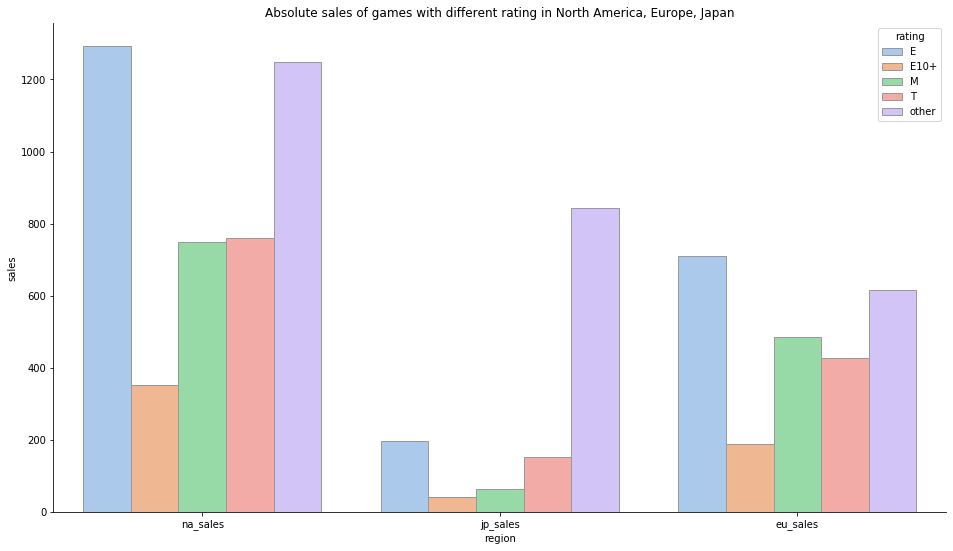

In [59]:
#top_ratings = ['E', 'T', 'M', 'E10+', 'other']

df_total = (df.groupby('rating')[['na_sales','jp_sales','eu_sales']].sum() #group to have sum for each rating
            .reset_index()
            .melt(id_vars='rating') #melt for it to be easily plotted
           )
df_total.columns = ['rating', 'region', 'sales']
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title('Absolute sales of games with different rating in North America, Europe, Japan')

sns.barplot(x='region', y='sales', hue='rating', data=df_total, palette="pastel", edgecolor=".6", ax=ax)
sns.despine(fig)

To be percise I'll make another comparacement, but now I won't take sum of sales for each region, I'll take average sale of each game for every rating.

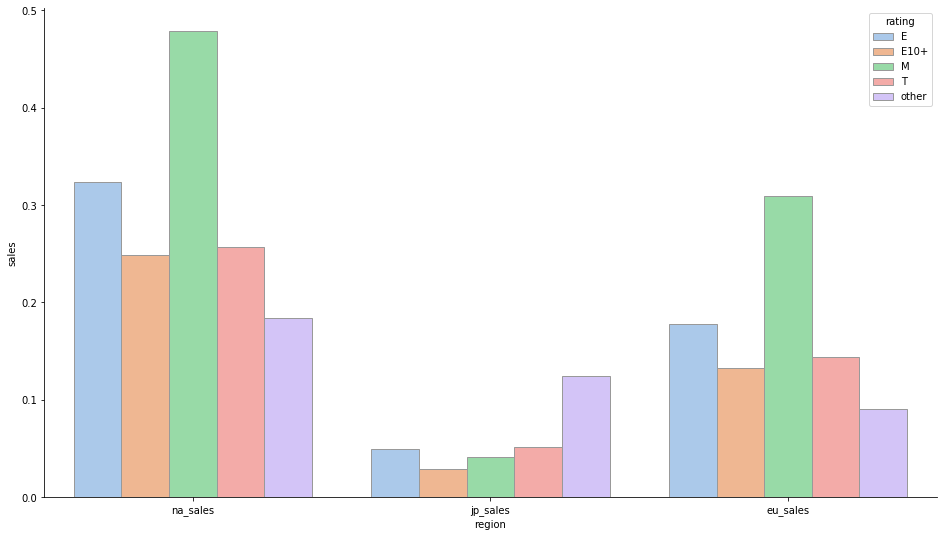

In [60]:
df_mean = (df.groupby('rating')[['na_sales','jp_sales','eu_sales']].mean() #group to have sum for each rating
            .reset_index()
            .melt(id_vars='rating') #melt for it to be easily plotted
           )
df_mean.columns = ['rating', 'region', 'sales']
ax.set_title('Average sales per game for games different rating in North America, Europe, Japan')
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x='region', y='sales', hue='rating', data=df_mean, palette="pastel", edgecolor=".6", ax=ax)
sns.despine(fig)

### Conclusions:

* There is different importance of game ratings in different regions. Most of the games sold in Japan don't have assigned ESRP rating, but in US and in EU this rating seems to be more important. Maybe Japan uses its own game rating cryteria, that differs from international.
* Alltogether games with "E" rating make more money than games with other ratings (in NA and EU), but each game with M rating seems to have on average higher profit than games with any other genre. This diefference may be due to the fact that there are actually more games reliesed with lower ratings (like E or E10+), but there games wwith M seem to show more quality due to limits of age groups that they are designed for).
* Therefore I will recomend for the store owner to sell huge variety of games with "E" rating, but have high quantity of popular "M" games in stock (especially in NA and EU).


## Step 5. Test hypotheses

### Average user ratings of the Xbox One and PC platforms are the same.

Null hypothesys always needs to be a positive one for this test to be correct. Therefore our hypothesis is <b>Average user ratings of the Xbox One and PC platforms are the same. </b>

Amount of values for Xbox One: 182
Amount of values for PC: 770
Variance of user score for XOne: 1.90
Variance of user score for PC: 2.34
Average user score for XOne: 6.52
Average user score for Pn: 7.06


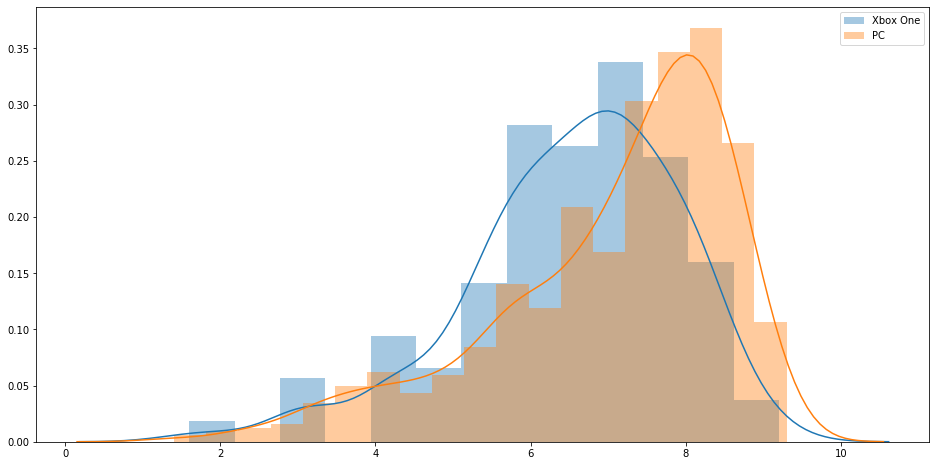

In [61]:
xbox_ratings = data.query('platform =="XOne"')['user_score'].dropna().tolist()
pc_ratings = data.query('platform == "PC"')['user_score'].dropna().tolist()


#check how does the data look
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(xbox_ratings, label='Xbox One');
sns.distplot(pc_ratings, label='PC');
plt.legend()
print ("Amount of values for Xbox One:", len(xbox_ratings))
print ("Amount of values for PC:", len(pc_ratings))

print ('Variance of user score for XOne: {:.2f}'.format(np.var(xbox_ratings)))
print ('Variance of user score for PC: {:.2f}'.format(np.var(pc_ratings)))
print ('Average user score for XOne: {:.2f}'.format(mean(xbox_ratings)))
print ('Average user score for Pn: {:.2f}'.format(mean(pc_ratings)))

I see that the distribution of data isn't normal, both datasets are negatively skewed, so it would be better to use Mann–Whitney U test, but because we haven't learned it yet, I will use A-B test. I'm going to use alpha value of 5% because it's industry standart and I don't see any reason to use more o less conservative alpha. They have simillar valiances, and they have been taken from populations with similar parameters, therefore we can consider their variances equal.

In [62]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis



    
results = st.ttest_ind(
    xbox_ratings,
    pc_ratings)

print('p-value: {:.6f}'.format(results.pvalue))

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value: 0.000014
We reject the null hypothesis


### Conclusion

Average user ratings for Xbox One and for PC are not the same.

### Average user ratings for the Action and Sports genres are different.


Right null hypothesys here is: <b> Average user ratings for the Action and Sports genres are the same. </b>

Amount of values for action games: 1830
Amount of values for sports games: 1103
Variance of user score for action games: 2.03
Variance of user score for sports game: 2.59
Average user score for action games: 7.05
Average user score for sports game: 6.96


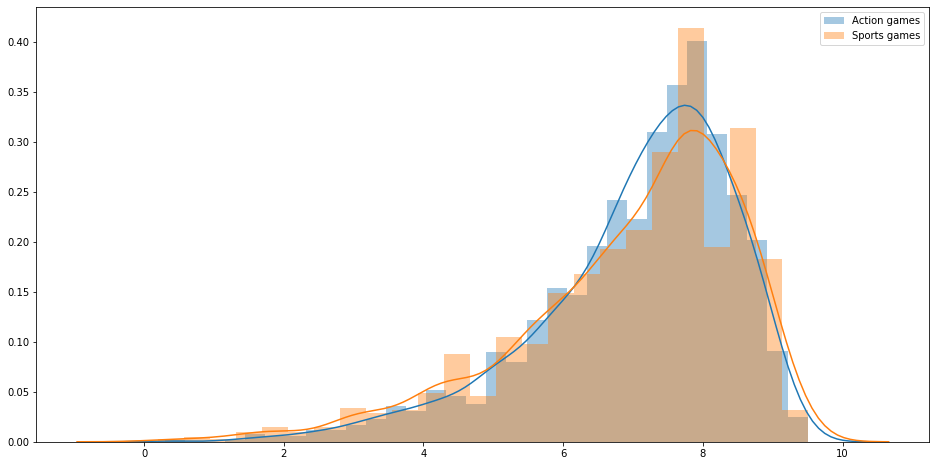

In [63]:
action_ratings = data.query('genre =="Action"')['user_score'].dropna().tolist()
sports_ratings = data.query('genre == "Sports"')['user_score'].dropna().tolist()


#check how does the data look
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(action_ratings, label='Action games');
sns.distplot(sports_ratings, label='Sports games');
plt.legend();

print ("Amount of values for action games:", len(action_ratings))
print ("Amount of values for sports games:", len(sports_ratings))

print ('Variance of user score for action games: {:.2f}'.format(np.var(action_ratings)))
print ('Variance of user score for sports game: {:.2f}'.format(np.var(sports_ratings)))
print ('Average user score for action games: {:.2f}'.format(mean(action_ratings)))
print ('Average user score for sports game: {:.2f}'.format(mean(sports_ratings)))

The distribution of data isn't normal, both datasets are negatively skewed, so it would be better to use Mann–Whitney U test, but I will use A-B test. I'm going to use alpha value of 5% because it's industry standart and I don't see any reason to use more o less conservative alpha. They have simillar valiances, and they have been taken from populations with similar parameters, therefore we can consider their variances equal.

In [64]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

    
results = st.ttest_ind(
    action_ratings,
    sports_ratings)

print('p-value: {:.6f}'.format(results.pvalue))

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value: 0.104070
We can't reject the null hypothesis


### Conclusion

We can't make definite conclusion if user scores for sport games and for  action games are the same or different.

# General conclusion

My conclusions will mostly be recomendations for online-store based on the analysis that I have made.

* First and faremost important conclusion is that the industry is now in stable/declining state. There aren't any platforms that show any rise and worldwide sales are going down;
* On average one platform has a lifespan of 8-10 years;
* There is no need to invest money in selling games for old platforms;
* The most popular platfroms now are PS4 and XOne, they still have some time to live left, but there may be some new platforms coming out next year or two (due to decline of current ones);
* There are game genres that tend to stay popular throughout the years, like action and sports, shooters seem to be gaining popularity for last years. Some genres are never popular, like Strategy;
* Japan market is very different from NA and EU market: different platforms are popular in Japan (nobody plays Xbox, and everybody play PS), different genres are popular (role-playing is a huge thing there) and ESRP ratings don't affect the price of games;
* I will recomend for the store owner to try to sell huge variety of games with "E" rating, but have high quantity of popular "M" games in stock (this only applies to NA and EU);
* Games that have good crotic score seem to have higher sales, but that's not always the point, some of the highest selling games have had very low critic score. So a good recomendation here is to pay attention to it, but not to have it as a valuable point of making decision;
* Users tend to love and to hate all the games: with high critic score, with low, with high and low sales. So user rating should never be a deciding point of promoting/selling/stocking games.